### Spatial Understanding with Qwen2.5-VL

This notebook showcases Qwen2.5-VL's advanced spatial localization abilities, including accurate object detection and specific target grounding within images. 

See how it integrates visual and linguistic understanding to interpret complex scenes effectively.

Prepare the environment

In [1]:
# !pip install git+https://github.com/huggingface/transformers
# !pip install qwen-vl-utils
# !pip install openai

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-4lad9upj
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-4lad9upj
  Resolved https://github.com/huggingface/transformers to commit 8ede897c30372c7c01a2ce12323eb08295543b28
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10857439 sha256=2cc690fdb5f2a3fb2f2c7a021677a2dec88e8f5e12431d43064073bb10ab96a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-lq5erk5k/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.2
    Uninstalling transformers-4.48.2:
      Successfully uninstalled transformers-4.48.2


#### \[Setup\]

Load visualization utils.

In [1]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
# !apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  img.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

Load model and processors.

In [2]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Load inference function.

In [3]:
def inference(img_url, prompt, system_prompt="You are a helpful assistant", max_new_tokens=1024):
  image = Image.open(img_url)
  messages = [
    {
      "role": "system",
      "content": system_prompt
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "image": img_url
        }
      ]
    }
  ]
  text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  print("input:\n",text)
  inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')

  output_ids = model.generate(**inputs, max_new_tokens=1024)
  generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
  output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
  print("output:\n",output_text[0])

  input_height = inputs['image_grid_thw'][0][1]*14
  input_width = inputs['image_grid_thw'][0][2]*14

  return output_text[0], input_height, input_width

inference function with API

In [4]:
from openai import OpenAI
import os
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", model_id="qwen2.5-vl-72b-instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    client = OpenAI(
        #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        api_key=os.getenv('DASHSCOPE_API_KEY'),
        base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

In [10]:
image_path = "/home/ubuntu/aws-genai-try-it-on/assets/pics/forbiden.jpg"


## Use a local HuggingFace model to inference.
# prompt in chinese
prompt = "我正在审核这张图片的合规性，确认这张图不合规或包含敏感信息，清识别这张图中的什么内容不合规，框出该物品在图中的bbox坐标，并以json格式输出"
# prompt in english
# prompt = "Outline the position of each small cake and output all the coordinates in JSON format."
response, input_height, input_width = inference(image_path, prompt)

# image = Image.open(image_path)
# print(image.size)
# image.thumbnail([640,640], Image.Resampling.LANCZOS)
# plot_bounding_boxes(image,response,input_width,input_height)

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
我正在审核这张图片的合规性，确认这张图不合规或包含敏感信息，清识别这张图中的什么内容不合规，框出该物品在图中的bbox坐标，并以json格式输出<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



output:
 这张图片中没有发现任何不合规的内容。图片显示的是一个人坐在桌子后面，桌子上有一些文件、茶杯和麦克风。图片中的人物是公开人物，且背景和环境看起来是正式场合。因此，这张图片是合规的。

```json
[]
```


#### 1. Detect certain object in the image

Let's start with a simple scenario where we want to locate certain objects in an image.

Besides, we can further prompt the model to describe their unique characteristics or features by explicitly giving that order.

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Outline the position of each small cake and output all the coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



output:
 ```json
[
	{"bbox_2d": [43, 576, 204, 751], "label": "small cake"},
	{"bbox_2d": [140, 778, 319, 956], "label": "small cake"},
	{"bbox_2d": [368, 680, 536, 849], "label": "small cake"},
	{"bbox_2d": [310, 567, 459, 729], "label": "small cake"},
	{"bbox_2d": [534, 579, 689, 738], "label": "small cake"},
	{"bbox_2d": [652, 493, 799, 662], "label": "small cake"},
	{"bbox_2d": [830, 526, 995, 715], "label": "small cake"},
	{"bbox_2d": [766, 393, 895, 552], "label": "small cake"},
	{"bbox_2d": [552, 369, 676, 542], "label": "small cake"},
	{"bbox_2d": [411, 381, 519, 520], "label": "small cake"},
	{"bbox_2d": [262, 393, 384, 557], "label": "small cake"},
	{"bbox_2d": [70, 408, 212, 593], "label": "small cake"}
]
```
(1024, 1024)
(640, 640)


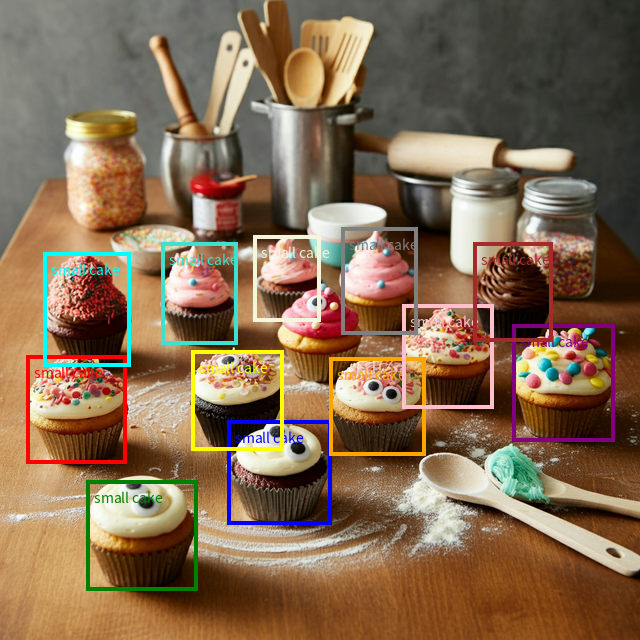

In [9]:
image_path = "/home/ubuntu/aws-genai-try-it-on/assets/pics/cakes.png"


## Use a local HuggingFace model to inference.
# prompt in chinese
prompt = "框出每一个小蛋糕的位置，以json格式输出所有的坐标"
# prompt in english
prompt = "Outline the position of each small cake and output all the coordinates in JSON format."
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
print(image.size)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)




## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)


#### 2. Detect a specific object using descriptions

Further, you can search for a specific object by using a short phrase or sentence to describe it.

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Locate the top right brown cake, output its bbox coordinates using JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



output:
 ```json
[
	{"bbox_2d": [765, 394, 891, 550], "label": "top right brown cake"}
]
```
(640, 640)


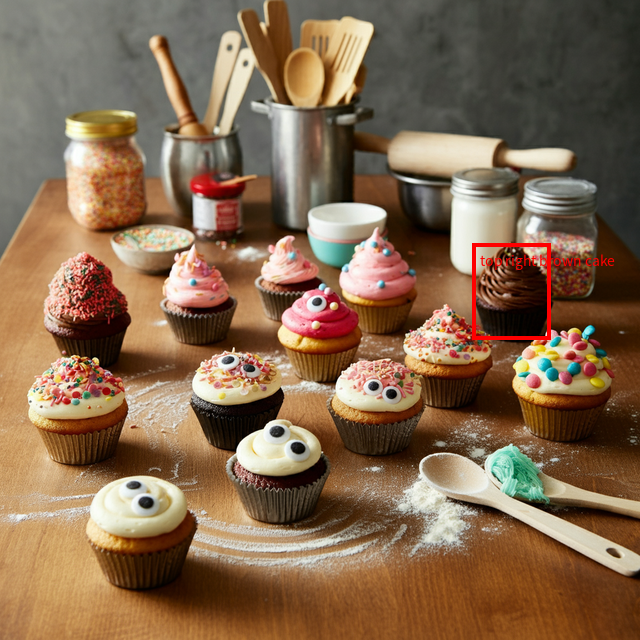

In [10]:
image_path = "/home/ubuntu/aws-genai-try-it-on/assets/pics/cakes.png"

# prompt in chinses
prompt = "定位最右上角的棕色蛋糕，以JSON格式输出其bbox坐标"
# prompt in english
prompt = "Locate the top right brown cake, output its bbox coordinates using JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 3. Point to certain objects in xml format

In addition to the above mentioned bbox format [x1, y1, x2, y2], Qwen2.5-VL also supports point-based grounding. You can point to a specific object and the model is trained to output xml-style results.

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
point to the rolling pin on the far side of the table, output its coordinates in XML format <points x y>object</points><|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



output:
 ```xml
<points x1="743" y1="250" alt="rolling pin on the far side of the table">rolling pin on the far side of the table</points>
```


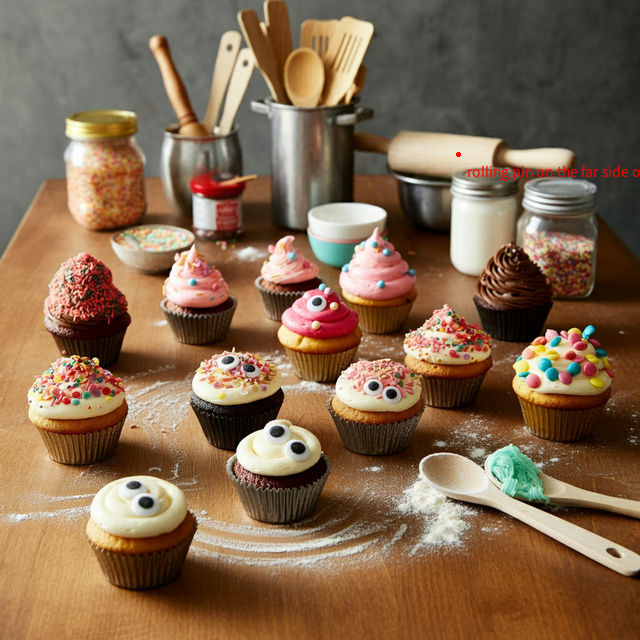

In [11]:
image_path = "/home/ubuntu/aws-genai-try-it-on/assets/pics/cakes.png"

# prompt in chinese
prompt = "以点的形式定位图中桌子远处的擀面杖，以XML格式输出其坐标"
# prompt in english
prompt = "point to the rolling pin on the far side of the table, output its coordinates in XML format <points x y>object</points>"

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_points(image, response, input_width, input_height)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_points(image, response, input_width, input_height)

#### 4. Reasoning capability

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Locate the shadow of the paper fox, report the bbox coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



output:
 ```json
[
	{"bbox_2d": [1098, 1304, 1576, 1900], "label": "shadow of the paper fox"}
]
```
(640, 482)


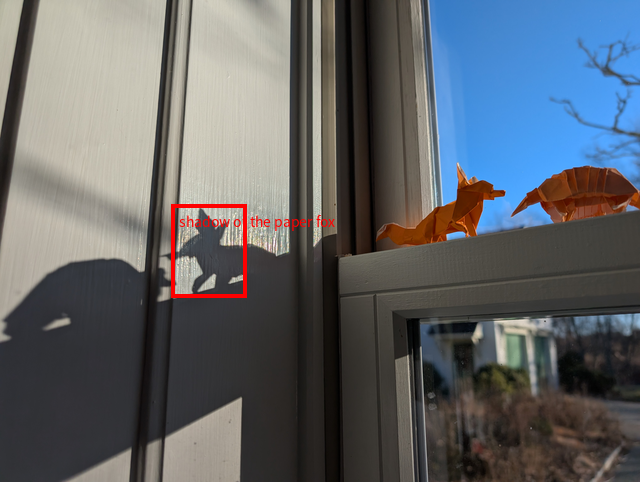

In [12]:
image_path = "/home/ubuntu/aws-genai-try-it-on/assets/pics/Origamis.jpg"

# prompt in chinese
prompt = "框出图中纸狐狸的影子，以json格式输出其bbox坐标"
# prompt in english
prompt = "Locate the shadow of the paper fox, report the bbox coordinates in JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 5. Understand relationships across different instances

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Locate the person who act bravely, report the bbox coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



output:
 ```json
[
	{"bbox_2d": [74, 58, 526, 623], "label": "person who acts bravely"}
]
```
(640, 360)


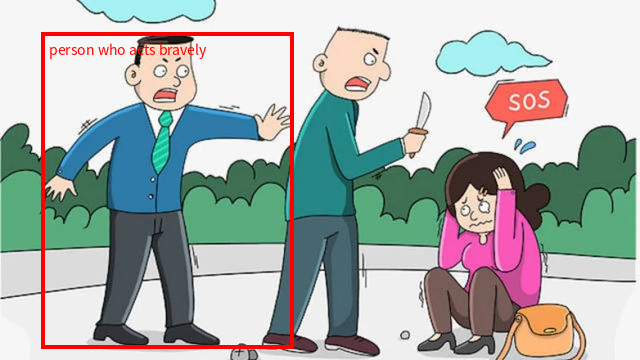

In [13]:
image_path = "/home/ubuntu/aws-genai-try-it-on/assets/pics//cartoon_brave_person.jpeg"

# prompt in chinese
prompt = "框出图中见义勇为的人，以json格式输出其bbox坐标"
# prompt in english
prompt = "Locate the person who act bravely, report the bbox coordinates in JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)


## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 6. Find a special instance with unique characteristic (color, location, utility, ...)

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
If the sun is very glaring, which item in this image should I use? Please locate it in the image with its bbox coordinates and its name and output in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



output:
 ```json
[
	{"bbox_2d": [150, 196, 308, 279], "label": "sunglasses"}
]
```
(640, 465)


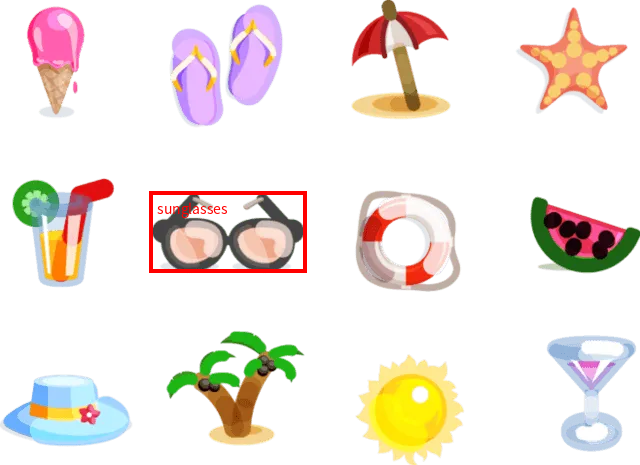

In [14]:
url = "/home/ubuntu/aws-genai-try-it-on/assets/pics//multiple_items.png"

# prompt in chinese
prompt = "如果太阳很刺眼，我应该用这张图中的什么物品，框出该物品在图中的bbox坐标，并以json格式输出"
# prompt in english
prompt = "If the sun is very glaring, which item in this image should I use? Please locate it in the image with its bbox coordinates and its name and output in JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)


## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 7. Use Qwen2.5-VL grounding capabilities to help counting

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Please first output bbox coordinates and names of every item in this image in JSON format, and then answer how many items are there in the image.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



output:
 ```json
[
    {"bbox_2d": [25, 6, 87, 124], "label": "ice cream"},
    {"bbox_2d": [169, 3, 288, 130], "label": "flip-flops"},
    {"bbox_2d": [349, 0, 456, 124], "label": "beach umbrella"},
    {"bbox_2d": [519, 5, 635, 124], "label": "starfish"},
    {"bbox_2d": [14, 182, 118, 297], "label": "cocktail drink"},
    {"bbox_2d": [150, 196, 308, 282], "label": "sunglasses"},
    {"bbox_2d": [354, 196, 466, 300], "label": "lifebuoy"},
    {"bbox_2d": [532, 198, 644, 297], "label": "watermelon slice"},
    {"bbox_2d": [2, 383, 134, 476], "label": "hat"},
    {"bbox_2d": [168, 336, 308, 462], "label": "palm tree"},
    {"bbox_2d": [354, 364, 469, 476], "label": "sun"},
    {"bbox_2d": [548, 342, 644, 476], "label": "martini glass"}
]
```

There are 12 items in the image.
(640, 465)


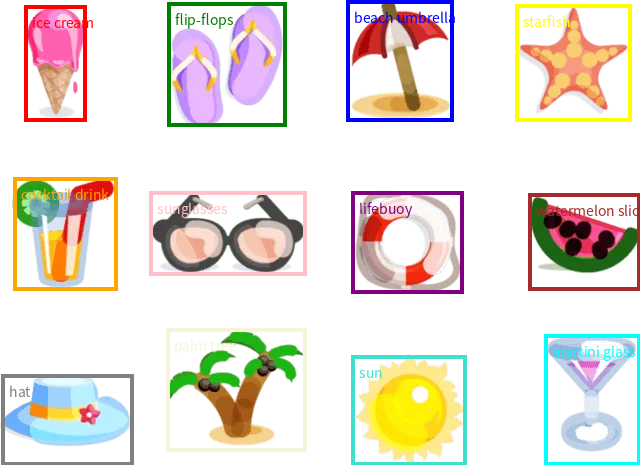

In [15]:
image_path = "/home/ubuntu/aws-genai-try-it-on/assets/pics//multiple_items.png"

# prompt in chinese
prompt = "请以JSON格式输出图中所有物体bbox的坐标以及它们的名字，然后基于检测结果回答以下问题：图中物体的数目是多少？"
# prompt in english
prompt = "Please first output bbox coordinates and names of every item in this image in JSON format, and then answer how many items are there in the image."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

# # Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 8. spatial understanding with designed system prompt
The above usage is based on the default system prompt. You can also change the system prompt to obtain other output format like plain text.
Qwen2.5-VL now support these formats:
* bbox-format: JSON

`{"bbox_2d": [x1, y1, x2, y2], "label": "object name/description"}`

* bbox-format: plain text

`x1,y1,x2,y2 object_name/description`

* point-format: XML

`<points x y>object_name/description</points>`

* point-format: JSON

`{"point_2d": [x, y], "label": "object name/description"}`

Change your system prompt to use plain text as output format

In [16]:
image_path = "/home/ubuntu/aws-genai-try-it-on/assets/pics/cakes.png"
image = Image.open(image_path)
system_prompt = "As an AI assistant, you specialize in accurate image object detection, delivering coordinates in plain text format 'x1,y1,x2,y2 object'."
prompt = "find all cakes"
response, input_height, input_width = inference(image_path, prompt, system_prompt=system_prompt)



## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# response = inference_with_api(image_path, prompt, sys_prompt=system_prompt)
# print(response)


input:
 <|im_start|>system
As an AI assistant, you specialize in accurate image object detection, delivering coordinates in plain text format 'x1,y1,x2,y2 object'.<|im_end|>
<|im_start|>user
find all cakes<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



output:
 43,378,995,956 cakes

